Data Structure:
  **Rows:**  
  - 0: Column Headers
  - 1 - 531 : Patient ID Number *(int)*

  **Columns:**
  - 0: DID *(int):* Patient ID
  - 1: Mutation *(string)*: CTL (Control), MAPT, C9orf72, GRN
  - 2: AGE_AT_VISIT *(int)*
  - 3: SEX_AT_BIRTH *(string)*: M, F
  - 4: Carrier.Status *(string)*: Carrier, CTL
  - 5: Gene.Dx *(string)*:  mutation status + clinical status
  (“PreSx” suffix = presymptomatic and “Sx” suffix = symptomatic)
  - 6: GLOBALCOG.ZCORE *(float)*: global cognition composite score
  - 7: FTLDCDR_SBL *(int)*: CDR sum of boxes - Clinical Dementia Rating Scale (CDR)
  is a global assessment instrument that yields global and Sum of Boxes (SOB) scores,
  with the global score regularly used in clinical and research settings
  to stage dementia severity. Higher is worse.
  - 8: NFL3_MEAN *(float):* plasma NfL concentrations
  - 9: HasPlasma? *(int)*: 1, 0 (519 Yes)
  - 10 - 7298: Proteins *(float)*:
    Protein variables are annotated as
    Protein Symbol | UniProt ID^Sequence ID| Matrix (CSF or PLASMA).
    The sequence ID is present only if there is more than one target
    for a given protein: e.g.,
    ABL2|P42684^SL010488@seq.3342.76|PLASMA ,
    ABL2|P42684^SL010488@seq.5261.13|PLASMA
  - 7299: HasCSF? *(int)*: 1, 0 (254 Yes)
  - 7300 - 14588: Proteins *(float)*:
  - 14589 - 15212: Clinical Data - maybe not necessary for right now.


/tmp/ipykernel_4082420/3460836005.py:6: DtypeWarning: Columns (14923,14929,14930,15002,15004,15005,15006,15007) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('datasets/data/ALLFTD_dataset_for_nina_louisa.csv')


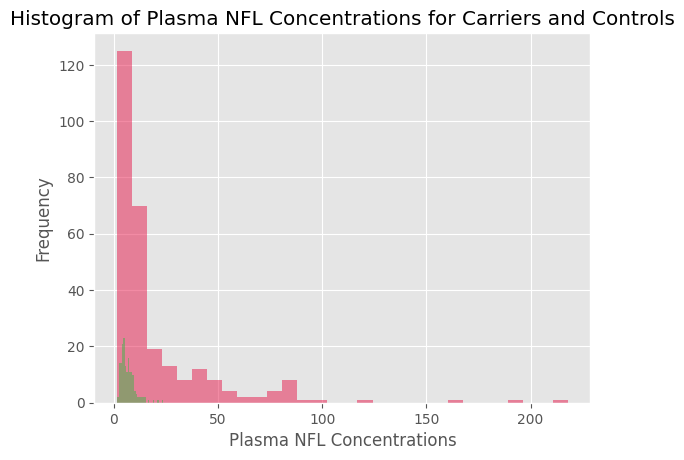

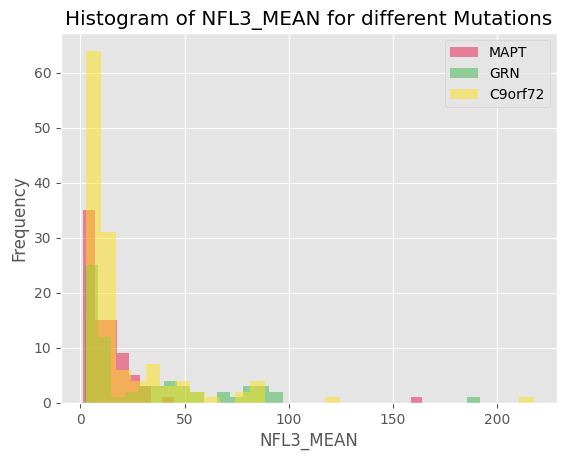

In [16]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

# Load the data
data = pd.read_csv('datasets/data/ALLFTD_dataset_for_nina_louisa.csv')

# Display the first few rows of the data
data.head()

#TO DO: make sure this number is correct
controls = data[data['Carrier.Status'].str.contains('CTL')]
# Plot a histogram of the 'NFL3_MEAN' column

carriers = data[data['Carrier.Status'].str.contains('Carrier')]

plt.hist(carriers['NFL3_MEAN'], bins=30, alpha=0.5, label='Carrier')
plt.hist(controls['NFL3_MEAN'], bins=30, alpha=0.5, label='Control')

# Add title and labels
plt.title('Histogram of Plasma NFL Concentrations for Carriers and Controls')
plt.xlabel('Plasma NFL Concentrations')
plt.ylabel('Frequency')

plt.figure()
plt.style.use('ggplot') 
my_palette = ['#e6194b', '#3cb44b', '#ffe119', '#0082c8', '#f58231', '#911eb4']
sns.set_palette(my_palette)

# Filter data based on Mutation
mapt_data = data[data['Mutation'] == 'MAPT']['NFL3_MEAN']
grn_data = data[data['Mutation'] == 'GRN']['NFL3_MEAN']
c903_data = data[data['Mutation'] == 'C9orf72']['NFL3_MEAN']

# Plot histograms
plt.hist(mapt_data, bins=30, alpha=0.5, label='MAPT')
plt.hist(grn_data, bins=30, alpha=0.5, label='GRN')
plt.hist(c903_data, bins=30, alpha=0.5, label='C9orf72')

plt.xlabel('NFL3_MEAN')
plt.ylabel('Frequency')
plt.title('Histogram of NFL3_MEAN for different Mutations')
plt.legend(loc='upper right')

plt.show()





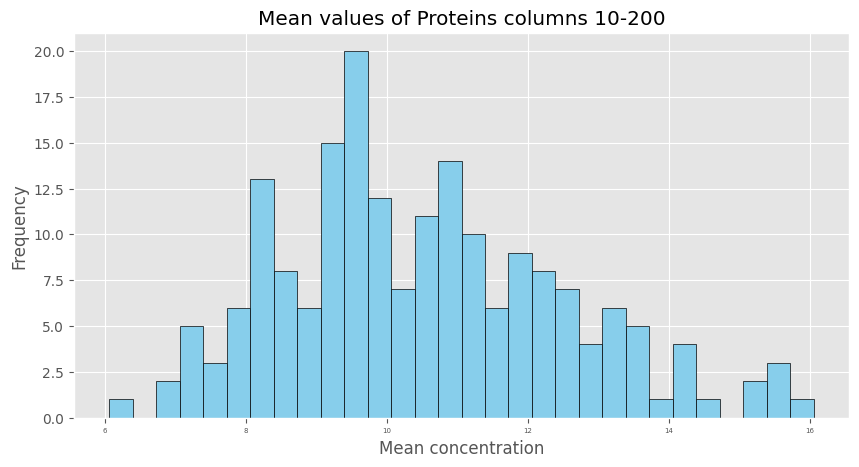

In [33]:
mean_values = data.iloc[:, 10:200].mean()

plt.figure(figsize=(10,5))
mean_values.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Mean values of Proteins columns 10-200')
plt.ylabel('Frequency')
plt.xlabel('Mean concentration')
plt.tick_params(axis='x', labelsize=5)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


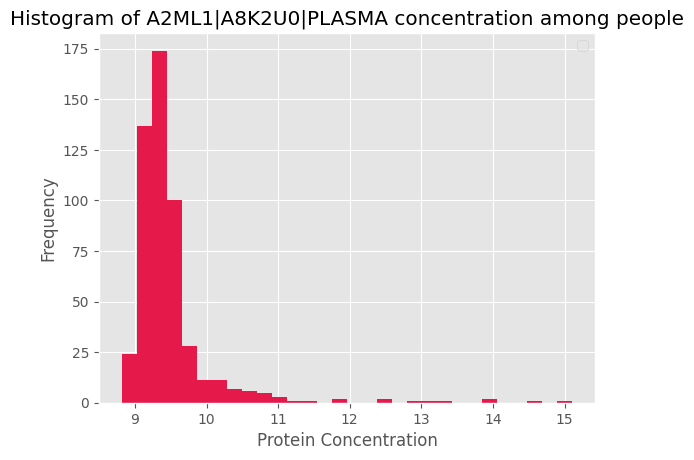

In [34]:
# Plot a histogram of column 30 protein concentration
data['A2ML1|A8K2U0|PLASMA'].hist(bins=30)
plt.xlabel('Protein Concentration')
plt.ylabel('Frequency')
plt.title('Histogram of A2ML1|A8K2U0|PLASMA concentration among people')
plt.legend(loc='upper right')

In [27]:
import os
import numpy as np
import pandas as pd

ROOT_DIR = "/home/lcornelis/code/proteo/proteo/datasets"

ADJACENCY_FOLDER = os.path.join(ROOT_DIR, "data", "ftd", "processed")
ADJACENCY_PATH = os.path.join(ADJACENCY_FOLDER, "adjacency_matrix.csv")

adj_matrix = np.array(pd.read_csv(ADJACENCY_PATH, header=None)).astype(float)


[[1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [1. 0. 1. 1. 0. 1. 1. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]
 [0. 1. 0. 0. 1. 0. 0. 1. 1. 1.]]


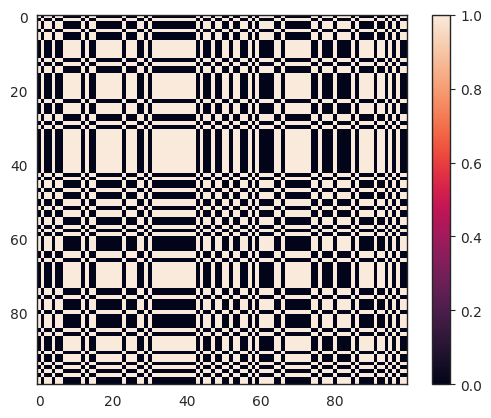

In [28]:
import matplotlib.pyplot as plt

plt.imshow(adj_matrix[:100, :100])
print(adj_matrix[:10, :10])
plt.colorbar();

calculating adjacency matrix ...
	Done..

[[1.00000000e+00 1.67622896e-03 3.06770457e-06 0.00000000e+00
  0.00000000e+00]
 [1.67622896e-03 1.00000000e+00 1.92919151e-07 0.00000000e+00
  0.00000000e+00]
 [3.06770457e-06 1.92919151e-07 1.00000000e+00 6.44152068e-06
  3.00126511e-04]
 [0.00000000e+00 0.00000000e+00 6.44152068e-06 1.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 3.00126511e-04 0.00000000e+00
  1.00000000e+00]]
[[1.00000000e+00 5.58406785e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [5.58406785e-04 1.00000000e+00 0.00000000e+00 0.00000000e+00
  1.13858207e-06]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 5.64747624e-05
  0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.64747624e-05 1.00000000e+00
  3.00331097e-09]
 [0.00000000e+00 1.13858207e-06 0.00000000e+00 3.00331097e-09
  1.00000000e+00]]


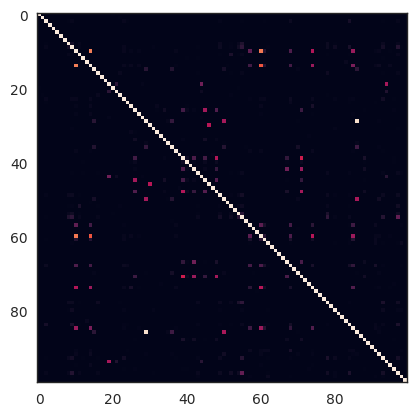

In [25]:
import PyWGCNA
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT_DIR = "/home/lcornelis/code/proteo/"
EXPRESSION_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_features_labels")
ADJ_FOLDER = os.path.join(ROOT_DIR, "MLA-GNN", "example_data", "input_adjacency_matrix")

# WGCNA parameters
# Probably not necessary since 6 is the default
wgcna_power = 6
wgcna_minModuleSize = 10
wgcna_mergeCutHeight = 0.25


# Read data
geneExp = pd.read_csv(os.path.join(EXPRESSION_FOLDER, "split1_train_320d_features_labels.csv"), header=None) # col = genes, rows = samples 

# Convert the relevant part of the DataFrame to a matrix
geneExp = geneExp.iloc[1:, 82:322].values.astype(float)

# Replace NA values with 0
geneExp = np.nan_to_num(geneExp)

# Calculate adjacency matrix.
adjacency = PyWGCNA.WGCNA.adjacency(geneExp, power = wgcna_power, adjacencyType="signed hybrid")
print(adjacency[:5, :5])
plt.imshow(adjacency[:100, :100])

real_adj = np.array(
        pd.read_csv(ADJ_FOLDER +'/'+ 'split1' + '_adjacency_matrix.csv', header=None),
    ).astype(float)
print("============")
print(real_adj[:5, :5])
